https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Bayesian%20Logistic%20Regression_bank%20marketing.ipynb

In [1]:
#!pip install pymc3==3.8

In [2]:
#!pip install arviz

In [3]:
from IPython.display import Image
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pymc3 as pm
import arviz as az
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

plt.rc("font", size=14)
pd.set_option('display.max_columns', 30)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
pd.set_option('display.max_columns', 30)

Using Theano backend.


In [5]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml1920/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [6]:
data = pd.read_csv(get_file('banking.csv', False), header=0)
data = data.dropna()
print(data.shape)
print(data.columns)

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


In [7]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [8]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [9]:
data['education'].replace(dict.fromkeys(['basic.4y', 'basic.6y', 'basic.9y'], 'Basic'), inplace=True)

After grouping, this is the columns.

In [10]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### Data exploration

In [11]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

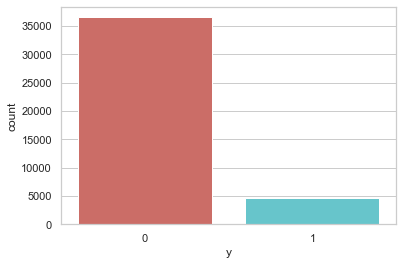

In [12]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [13]:
count_no_sub = data[data['y']==0].shape[0]
count_sub = data[data['y']==1].shape[0]
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Percentage of refusals: {0:5.2f}".format(pct_of_no_sub*100))
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Percentage of subscriptions: {0:5.2f}".format(pct_of_sub*100))

Percentage of refusals: 88.73
Percentage of subscriptions: 11.27


Our classes are inbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [14]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [15]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [16]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [17]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


Visualizations

Text(0, 0.5, 'Frequency of Purchase')

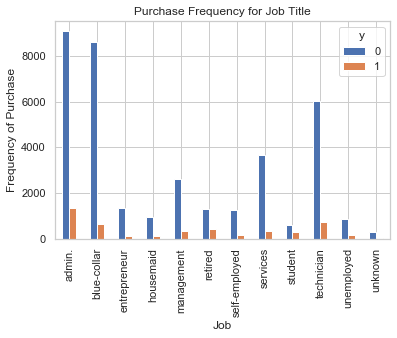

In [18]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

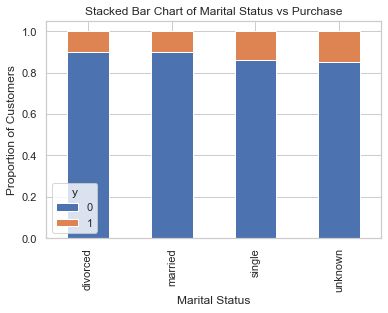

In [19]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

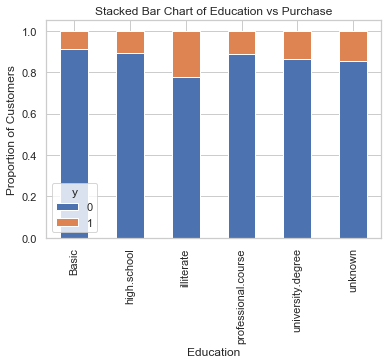

In [20]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Purchase')

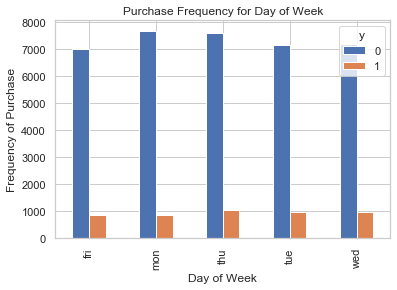

In [21]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

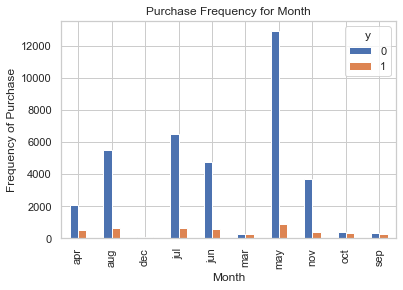

In [22]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

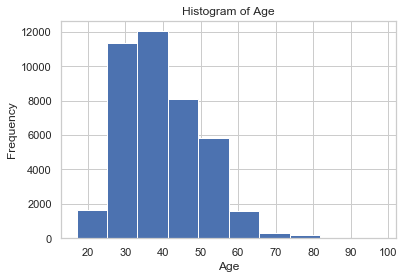

In [23]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Frequency of Purchase')

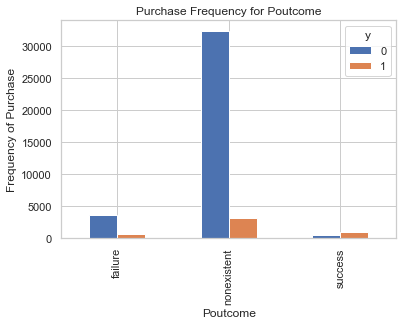

In [24]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [25]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [26]:
y = data['y']
X = data.drop(columns=['y'])

In [27]:
print('{0:5d} items, {1:5d} features'.format(X.shape[0], X.shape[1]))

41188 items,    20 features


In [28]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list = pd.get_dummies(X[var], prefix=var, dtype=np.float32)
    X=X.join(cat_list)
X=X.drop(columns=cat_vars)

In [29]:
print('{0:5d} items, {1:5d} features'.format(X.shape[0], X.shape[1]))

41188 items,    61 features


In [30]:
X.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
                         ...   
day_of_week_tue         float32
day_of_week_wed         float32
poutcome_failure        float32
poutcome_nonexistent    float32
poutcome_success        float32
Length: 61, dtype: object

### Recursive feature elimination

In [31]:
logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())

In [32]:
print(rfe.ranking_)
print(rfe.support_)

[40 31  9 33  1 13 19 17  1 29 23  1  3 39 32  1 30  1  1 21 26 38 37 28
 11 41  4  5 34  6 25 10  1 18 42 36 14 22 24 20 15 12  1  1  1  1  2 16
  1  1  1  1 35 27  1  8  7  1  1  1  1]
[False False False False  True False False False  True False False  True
 False False False  True False  True  True False False False False False
 False False False False False False False False  True False False False
 False False False False False False  True  True  True  True False False
  True  True  True  True False False  True False False  True  True  True
  True]


In [33]:
cols=X.columns[rfe.support_]

In [34]:
X_rfe = X[cols]

In [35]:
print('{0:5d} items, {1:5d} features'.format(X_rfe.shape[0], X_rfe.shape[1]))

41188 items,    20 features


### Checking feature relevance through p-values

In [36]:
logit_model=sm.Logit(y,X_rfe)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.280886
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.202     
Dependent Variable:   y                 AIC:               23178.2331
Date:                 2020-04-29 18:04  BIC:               23350.7512
No. Observations:     41188             Log-Likelihood:    -11569.   
Df Model:             19                LL-Null:           -14499.   
Df Residuals:         41168             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous              0.2100   0.0510   4.1159 0.0000  0.1100  0.3099
euribor3m       

In [37]:
cols_to_drop = [k for k in result.pvalues.keys() if result.pvalues[k]>0.01]

The p-values of some variables are high, therefore, we will remove them.

In [38]:
X_red=X_rfe.drop(columns=cols_to_drop)

In [39]:
print('{0:5d} items, {1:5d} features'.format(X_red.shape[0], X_red.shape[1]))

41188 items,    16 features


In [40]:
logit_model=sm.Logit(y,X_red)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.281103
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.201     
Dependent Variable:   y                 AIC:               23188.1269
Date:                 2020-04-29 18:04  BIC:               23326.1414
No. Observations:     41188             Log-Likelihood:    -11578.   
Df Model:             15                LL-Null:           -14499.   
Df Residuals:         41172             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous              0.2088   0.0510   4.0978 0.0000  0.1089  0.3087
euribor3m       

### Over-sampling using SMOTE

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.3, random_state=0)
columns = X_train.columns

In [42]:
print('Number of items: {0:5d}'.format(y.shape[0]))
print('Refusals: {0:5d}, {1:5.2f}%'.format(y[y==0].shape[0], 100*y[y==0].shape[0]/y.shape[0]))
print('Subscriptions: {0:5d}, {1:5.2f}%'.format(y[y==1].shape[0], 100*y[y==1].shape[0]/y.shape[0]))
print('Number of items in training set: {0:5d}'.format(y_train.shape[0]))
print('Refusals in training set: {0:5d}, {1:5.2f}%'.format(y_train[y_train==0].shape[0], 100*y_train[y_train==0].shape[0]/y_train.shape[0]))
print('Subscriptions in training set: {0:5d}, {1:5.2f}%'.format(y_train[y_train==1].shape[0], 100*y_train[y_train==1].shape[0]/y_train.shape[0]))
print('Number of items in test set: {0:5d}'.format(y_test.shape[0]))
print('Refusals in test set: {0:5d}, {1:5.2f}%'.format(y_test[y_test==0].shape[0], 100*y_test[y_test==0].shape[0]/y_test.shape[0]))
print('Subscriptions in test set: {0:5d}, {1:5.2f}%'.format(y_test[y_test==1].shape[0], 100*y_test[y_test==1].shape[0]/y_test.shape[0]))

Number of items: 41188
Refusals: 36548, 88.73%
Subscriptions:  4640, 11.27%
Number of items in training set: 28831
Refusals in training set: 25567, 88.68%
Subscriptions in training set:  3264, 11.32%
Number of items in test set: 12357
Refusals in test set: 10981, 88.86%
Subscriptions in test set:  1376, 11.14%


In [43]:
os = SMOTE(random_state=0)
X_bal,y_bal =os.fit_sample(X_train, y_train)

In [44]:
print("Length of oversampled training set: {0:5d}".format(y_bal.shape[0]))
print("Number of refusals in oversampled training set: {0:5d}".format(y_bal[y_bal==0].shape[0]))
print("Number of subscriptions in oversampled training set: {0:5d}".format(y_bal[y_bal==1].shape[0]))
print("Proportion of refusals in oversampled training set: {0:5.2f}".format(y_bal[y_bal==0].shape[0]/y_bal.shape[0]))
print("Proportion of subscriptions in oversampled training set: {0:5.2f}".format(y_bal[y_bal==1].shape[0]/y_bal.shape[0]))

Length of oversampled training set: 51134
Number of refusals in oversampled training set: 25567
Number of subscriptions in oversampled training set: 25567
Proportion of refusals in oversampled training set:  0.50
Proportion of subscriptions in oversampled training set:  0.50


### Logistic Regression Model Fitting

In [45]:
#X_train, X_test, y_train, y_test = train_test_split(X_rr, y_r, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg = logreg.fit(X_bal, y_bal)

In [46]:
pred_proba_df = pd.DataFrame(logreg.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
meas_list = {}
max_meas_threshold = -1
for i in threshold_list:
    y_pred = pred_proba_df[1].map(lambda x: 1 if x>i else 0)
    test_measure = metrics.fbeta_score(y_pred,y_test,1.5)
    meas_list[i]=test_measure
    if max_meas_threshold == -1:
        max_meas_threshold = i
    elif meas_list[max_meas_threshold]<test_measure:
        max_meas_threshold = i
        
y_pred_best = pred_proba_df[1].apply(lambda x: 1 if x>max_meas_threshold else 0)
print(confusion_matrix(y_test, y_pred_best))
#print(metrics.fbeta_score(y_pred_best,y_test,1.5))
print(metrics.classification_report(y_pred_best,y_test))

[[10161   820]
 [  686   690]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     10847
           1       0.50      0.46      0.48      1510

    accuracy                           0.88     12357
   macro avg       0.71      0.70      0.70     12357
weighted avg       0.87      0.88      0.88     12357



In [47]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_pred,y_test))

Accuracy of logistic regression classifier on test set: 0.78
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      9197
           1       0.68      0.29      0.41      3160

    accuracy                           0.78     12357
   macro avg       0.74      0.62      0.64     12357
weighted avg       0.77      0.78      0.75     12357



### ROC

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

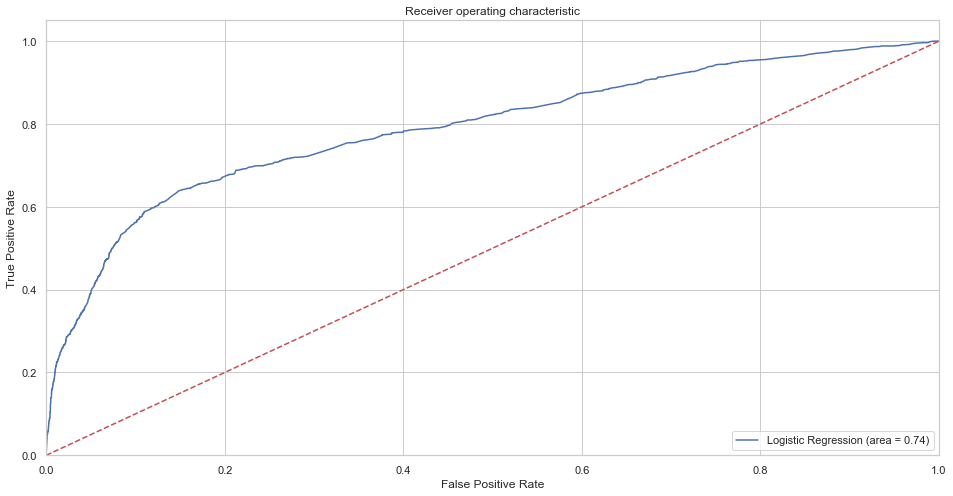

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(16,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [49]:
feat = 'euribor3m'
x_0 = X_bal[feat].values
x_c = x_0 - x_0.mean()

In [50]:
y_l = np.array(y_bal).ravel()

In [52]:
with pm.Model() as model_simple:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_c, beta))    
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha/beta)
    
    y_1 = pm.Bernoulli('y_1', p=theta, observed=y_l)
    #trace_simple = pm.sample(1000, tune=1000)

In [53]:
#with model_simple:
#    trace_simple = pm.sample(1000, tune=1000)
#   pm.save_trace(trace_simple, 'logreg_simple.trace', overwrite=True)

In [54]:
with model_simple:
  trace_simple = pm.load_trace('logreg_simple.trace') 

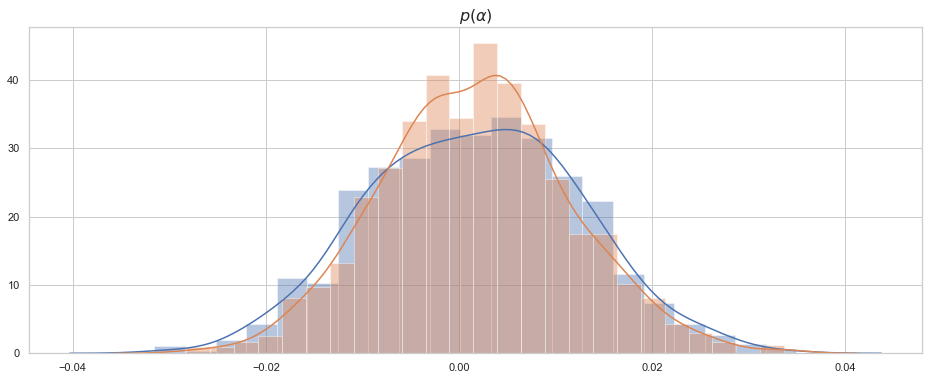

In [55]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace_simple.get_values('alpha', burn=50, combine=False)[0])
sns.distplot(trace_simple.get_values('alpha', burn=50, combine=False)[1])
plt.title(r'$p(\alpha)$', fontsize=16)
plt.show()

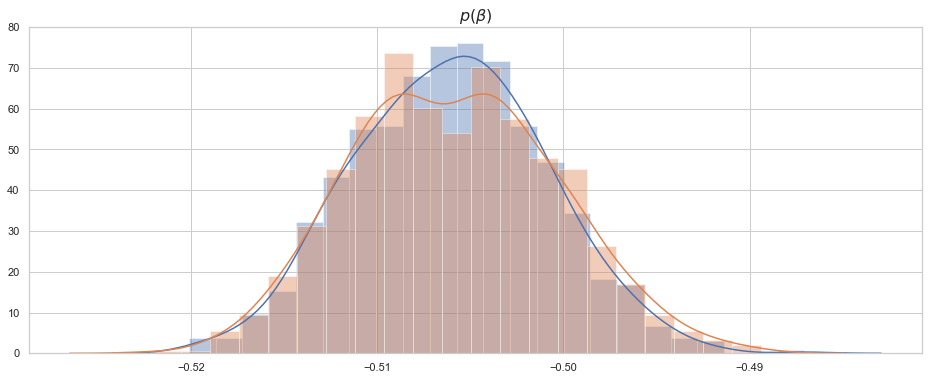

In [56]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace_simple.get_values('beta', burn=50, combine=False)[0])
sns.distplot(trace_simple.get_values('beta', burn=50, combine=False)[1])
plt.title(r'$p(\beta)$', fontsize=16)
plt.show()

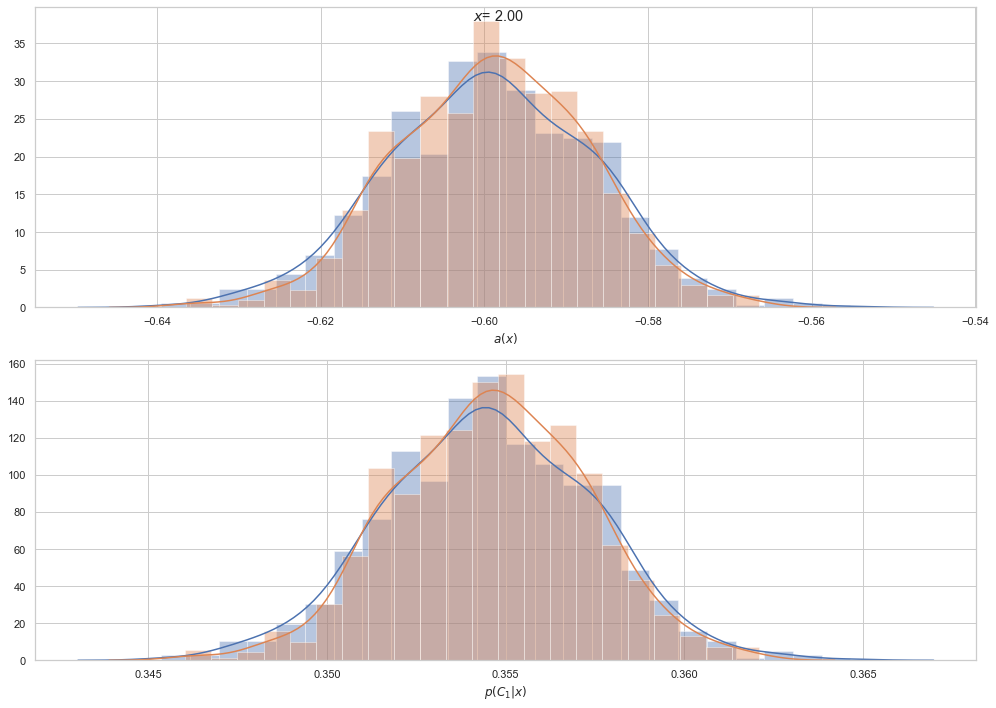

In [57]:
i=100
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
sns.distplot(trace_simple.get_values('mu', burn=50, combine=False)[0][:,0])
sns.distplot(trace_simple.get_values('mu', burn=50, combine=False)[1][:,0])
plt.xlabel('$a(x)$')
plt.subplot(2,1,2)
sns.distplot(trace_simple.get_values('theta', burn=50, combine=False)[0][:,0])
sns.distplot(trace_simple.get_values('theta', burn=50, combine=False)[1][:,0])
plt.xlabel('$p(C_1|x)$')
plt.suptitle('$x$={0:5.2f}'.format(x_c[i]))
plt.tight_layout()
plt.show()

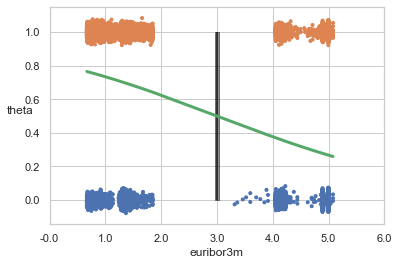

In [58]:
#plot probability prediction
theta_tr = trace_simple['theta'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta_tr[idx], color='C2', lw=3)
#plot borderline 
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
#highest posterior density interval for borderline
bd_hpd = az.hpd(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
#plot points in dataset + target
plt.scatter(np.array(x_c), np.random.normal(np.array(y_l), 0.02), marker='.', color=[f'C{x}' for x in y_l])

plt.xlabel(feat)
plt.ylabel('theta', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

In [59]:
ppc = pm.sample_ppc(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

100%|██████████| 500/500 [00:07<00:00, 69.51it/s] 


In [60]:
k = 3056
n1s = ppc['y_1'][:,k].sum()
n0s = ppc['y_1'].shape[0]-n1s
print('x: {0:5.8f}'.format(x_c[k]))
print('#1s: {0:5d}'.format(n1s))
print('#0s: {0:5d}'.format(n0s))
print('$p(C_1|x)$: {0:5.2f}'.format(n1s/(n0s+n1s)))

x: -2.32764641
#1s:   391
#0s:   109
$p(C_1|x)$:  0.78


In [61]:
print('Accuracy:', accuracy_score(preds, y_bal))
print('f1 score:', f1_score(preds, y_bal))

Accuracy: 0.7136738764814018
f1 score: 0.7123406094661767


In [62]:
data_bal = X_bal.copy()

data_bal = data_bal.rename(columns={'job_blue-collar':'job_bluecollar'})
cols = data_bal.columns
data_bal['y'] = y_bal
cols

Index(['previous', 'euribor3m', 'job_bluecollar', 'job_retired', 'job_student',
       'default_no', 'contact_telephone', 'month_apr', 'month_aug',
       'month_mar', 'month_may', 'month_nov', 'day_of_week_mon',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [63]:
with pm.Model() as logistic_model:
    coeffs = []
    w0 = pm.Normal('w0', mu=0, sd=10)
    for c in cols:
        w = pm.Normal(c, mu=0, sd=10)
        coeffs.append(w)
    
    mu = pm.Deterministic('mu', w0 + pm.math.dot(X_bal, coeffs))    
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    y_2 = pm.Bernoulli('y_2', p=theta, observed=y_l)

In [64]:
#with logistic_model:
#    trace_logreg = pm.sample(draws=500, tune=100, cores=1)
#    pm.save_trace(trace_logreg, 'logreg1_1.trace', overwrite=True)

In [65]:
with logistic_model:
  trace_logreg = pm.load_trace('logreg1_1.trace') 

In [318]:
#sf = 'y ~ '+cols[0]
#for c in cols[1:]:
#  sf = sf+' + '+c

In [319]:
#with pm.Model() as logistic_model_f:
#    pm.glm.GLM.from_formula(sf, data_bal, family = pm.glm.families.Binomial())

In [66]:
#with logistic_model_f:
#    trace_logreg_f = pm.sample(500, tune = 100, cores=1, init = 'adapt_diag')
#    pm.save_trace(trace_log_reg_f, 'logreg1_2.trace')

In [79]:
#with logistic_model:
  #trace_log_reg_f = pm.load_trace('logreg1_2.trace') 

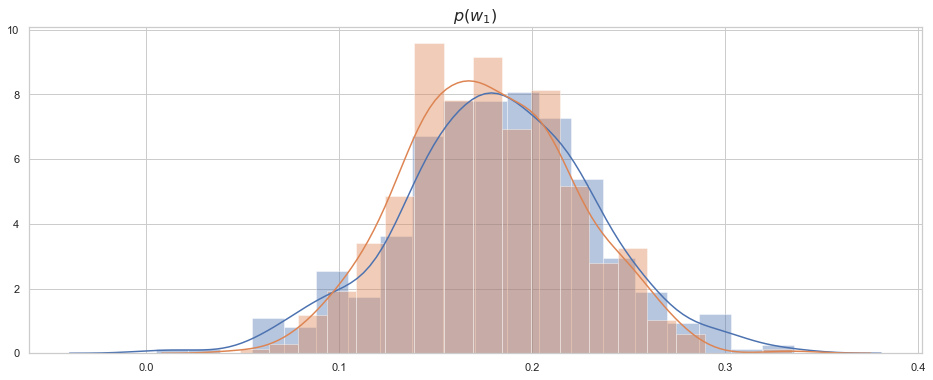

In [70]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace_logreg.get_values('previous', burn=50, combine=False)[0])
sns.distplot(trace_logreg.get_values('previous', burn=50, combine=False)[1])
plt.title(r'$p(w_1)$', fontsize=16)
plt.show()

In [72]:
ppc = pm.sample_ppc(trace_logreg, model=logistic_model, samples=500)
preds = np.rint(ppc['y_2'].mean(axis=0)).astype('int')

100%|██████████| 500/500 [00:21<00:00, 23.49it/s]


In [74]:
print('Accuracy of the simplest model:', accuracy_score(preds, y_bal))
print('f1 score of the simplest model:', f1_score(preds, y_bal))

Accuracy of the simplest model: 0.7283998904838268
f1 score of the simplest model: 0.7076702871095395
